In [1]:
from fastai.vision import *
import sys

import pose
import models.cs_v2 as cs
%load_ext autoreload
%autoreload 2

In [2]:
root = Path('../../LIP').resolve()
pose_label = pose.LIPLabel(root /'pose_annotations')
transforms = [pose.pose_flip_lr(p=0.5)], None
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=128, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=64)
        .normalize(imagenet_stats))

data.c = 16
data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [3]:
def loss(output, targets):
    is_visible = targets[..., 2] > 0
    gt = targets[..., :2][is_visible]
    output = output[is_visible]
    return pose.ce_loss(output, gt)

pckh = lambda learn: pose.Pckh(learn, lambda x: x)

In [10]:
learner = unet_learner(data, models.resnet18, callback_fns=pckh, loss_func=loss)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 1.32E-03


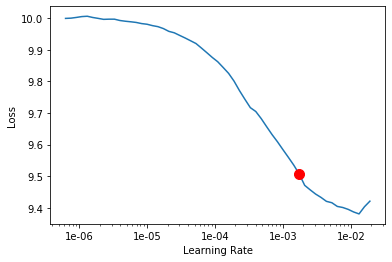

In [5]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [6]:
lr = 1e-3
learner.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,6.852740,6.550802,0.817536,0.655984,0.466431,0.418219,0.385481,0.399417,0.455049,0.594452,0.523576,01:45
1,6.401208,6.149942,0.852565,0.718819,0.586117,0.529395,0.493920,0.512776,0.520074,0.675508,0.611115,01:44
2,6.101085,5.910645,0.876777,0.764783,0.641922,0.580157,0.546620,0.568196,0.561109,0.719502,0.657542,01:44
3,5.841155,5.771915,0.888471,0.782427,0.671444,0.619069,0.571149,0.601168,0.585456,0.743596,0.682848,01:44
4,5.597341,5.747199,0.891150,0.790476,0.682515,0.630809,0.584101,0.614305,0.602082,0.751876,0.693330,01:44


In [7]:
learner.save('unet-stage1', return_path=True)

PosixPath('/home/labs/waic/omrik/LIP/models/unet-stage1.pth')

In [5]:
learner.load('unet-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding

In [6]:
learner.unfreeze()

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.20E-06


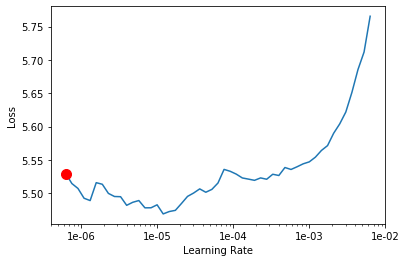

In [7]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [8]:
learner.fit_one_cycle(10, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,5.542749,5.747082,0.891407,0.790211,0.679649,0.628685,0.581703,0.614574,0.597363,0.750661,0.691748,03:49
1,5.515265,5.759953,0.890841,0.793034,0.683605,0.631305,0.580772,0.615828,0.603004,0.752838,0.693709,03:47
2,5.479449,5.764585,0.888420,0.793137,0.684979,0.632468,0.578200,0.616880,0.609660,0.752851,0.694171,03:40
3,5.413568,5.784892,0.888523,0.794387,0.683521,0.634888,0.580074,0.618239,0.608113,0.753412,0.694805,03:45
4,5.323194,5.826684,0.886307,0.792819,0.680917,0.630812,0.578209,0.620865,0.610207,0.750835,0.693487,03:43
5,5.213213,5.861728,0.886926,0.792824,0.684913,0.631310,0.575642,0.615623,0.608044,0.752090,0.692984,03:31
6,5.125170,5.916068,0.886256,0.794335,0.684501,0.631743,0.573071,0.615948,0.610888,0.752317,0.693083,01:48
7,5.065281,5.959186,0.887544,0.794389,0.682680,0.633773,0.572246,0.615294,0.611127,0.752691,0.693132,01:49
8,4.992800,5.981577,0.886668,0.794755,0.683250,0.633033,0.570216,0.616017,0.609653,0.752531,0.692663,01:48
9,4.985474,5.995732,0.885586,0.793606,0.681816,0.634159,0.569837,0.615824,0.610346,0.751863,0.692242,01:48


In [9]:
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=256, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=32)
        .normalize(imagenet_stats))

data.c = 16
data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: PoseLabelList
Pose (8/16) (256, 256),Pose (7/16) (256, 256),Pose (6/16) (256, 256),Pose (14/16) (256, 256),Pose (1/16) (256, 256)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: PoseLabelList
Pose (14/16) (256, 256),Pose (16/16) (256, 256),Pose (10/16) (256, 256),Pose (16/16) (256, 256),Pose (10/16) (256, 256)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [13]:
learner.data = data

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.91E-05


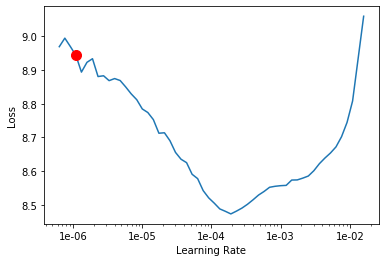

In [14]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [15]:
learner.fit_one_cycle(10, slice(1e-6, 2e-5))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,7.765841,7.469495,0.867865,0.769589,0.613337,0.586409,0.434051,0.426800,0.448880,0.712904,0.606772,06:42
1,7.511814,7.189474,0.886050,0.796791,0.661147,0.635398,0.508374,0.522543,0.513195,0.748030,0.658539,06:40
2,7.309087,7.063398,0.894653,0.806656,0.685137,0.661311,0.539908,0.570930,0.531992,0.764885,0.681777,06:40
3,7.206675,6.987391,0.897692,0.815063,0.699445,0.673395,0.562685,0.597328,0.560064,0.774221,0.697277,06:40
4,7.143595,6.953377,0.901607,0.820703,0.709958,0.680302,0.567125,0.612723,0.576231,0.780925,0.705740,06:40
5,7.048894,6.929173,0.903256,0.822637,0.717737,0.684346,0.573623,0.618951,0.587463,0.784718,0.711039,06:44
6,7.003222,6.915852,0.903101,0.825614,0.721876,0.686171,0.580409,0.625116,0.594107,0.786895,0.714887,06:42
7,6.984497,6.915814,0.903204,0.825610,0.722485,0.689119,0.579970,0.626028,0.593961,0.787777,0.715464,06:43
8,6.974652,6.907261,0.903719,0.826708,0.723079,0.690981,0.582152,0.627936,0.598908,0.788778,0.717178,06:40
9,6.950764,6.909493,0.903307,0.826133,0.723067,0.691116,0.581880,0.627988,0.598053,0.788565,0.716923,06:40


In [16]:
learner.fit_one_cycle(20, slice(1e-6, 2e-5))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,6.923688,6.908351,0.904286,0.826708,0.723349,0.691909,0.583139,0.627015,0.596970,0.789219,0.717277,06:40
1,6.939514,6.904487,0.904234,0.827701,0.725573,0.691807,0.585265,0.632062,0.600223,0.789980,0.719049,06:40
2,6.970772,6.898823,0.904441,0.829423,0.727778,0.694867,0.585810,0.632578,0.601767,0.791743,0.720450,06:40
3,6.959572,6.893138,0.904338,0.828223,0.728925,0.696161,0.588256,0.635090,0.602699,0.791997,0.721389,06:40
4,6.912437,6.884337,0.907016,0.831512,0.730471,0.697890,0.592801,0.638745,0.607579,0.794334,0.724496,06:40
5,6.813572,6.881945,0.907583,0.831145,0.733483,0.698233,0.592198,0.645487,0.614380,0.795203,0.726515,06:40
6,6.822881,6.879565,0.907325,0.831825,0.733703,0.700335,0.596457,0.649763,0.613142,0.795870,0.727973,06:40
7,6.739063,6.882238,0.907686,0.831982,0.736652,0.699566,0.599957,0.649893,0.616394,0.796538,0.729275,06:40
8,6.734312,6.884260,0.907428,0.832607,0.736592,0.703597,0.600997,0.652248,0.619403,0.797580,0.730693,06:40
9,6.662729,6.890985,0.907944,0.833915,0.740295,0.705265,0.602790,0.653041,0.617796,0.799356,0.731986,06:40


## cut Unet

In [3]:
class CSUnet(nn.Module):
    def __init__(self, unet, n_classes):
        super().__init__()
        self.unet = unet
        middle_layer = unet[3]
        assert isinstance(middle_layer, nn.Sequential) and len(middle_layer) == 2
        middle_layer = middle_layer[0]
        self.hook = callbacks.hook_output(middle_layer)
        ni = middle_layer[0].weight.shape[0]
        self.bu_head = create_head(ni*2, n_classes)
        
    def forward(self, x):
        td = self.unet(x)
        bu = self.bu_head(self.hook.stored)
        return bu, td
    
def _resnet_split(m:nn.Module): 
    if isinstance(m, CSUnet):
        m = m.unet
    return (m[0][6],m[1])

def short_unet(body, n_classes, size, bu=False):
    unet = models.unet.DynamicUnet(body, n_classes, img_size=size)
    unet.layers = unet.layers[:-4]
    ni = unet[-1].conv2[0].weight.shape[1]
    unet.extend([res_block(ni), conv_layer(ni, n_classes, ks=1, use_activ=False, norm_type=None)])
    if bu:
        unet = CSUnet(unet, n_classes)
    return unet

def short_unet_learner(data:DataBunch, arch:Callable, bu=False, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = {'cut':-2, 'split':_resnet_split }
    body = create_body(arch, pretrained, cut)
    try:    size = data.train_ds[0][0].size
    except: size = next(iter(data.train_dl))[0].shape[-2:]
    model = to_device(short_unet(body, data.c, size, bu=bu), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    if isinstance(model, CSUnet):
        apply_init(model.bu_head, nn.init.kaiming_normal_)
        model = model.unet
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

In [5]:
learner = short_unet_learner(data, models.resnet18, callback_fns=pckh, loss_func=loss)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 1.91E-01


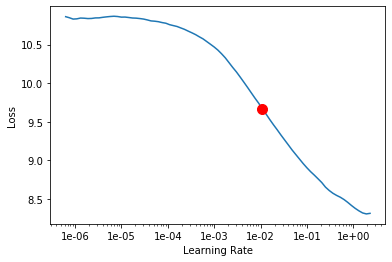

In [6]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [6]:
lr = 1e-2
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,5.460777,5.136261,0.814084,0.651743,0.459635,0.418789,0.408113,0.420937,0.465224,0.590873,0.528570,01:49
1,5.096459,4.808611,0.856120,0.726135,0.573654,0.524870,0.483835,0.478549,0.500521,0.674226,0.602429,01:22
2,4.909000,4.763698,0.861941,0.727395,0.572158,0.543993,0.490910,0.490827,0.485651,0.680303,0.607217,01:14
3,4.808388,4.608491,0.874202,0.755231,0.626342,0.578271,0.534772,0.557652,0.548047,0.712116,0.648477,01:14
4,4.721608,4.560440,0.877911,0.763855,0.641235,0.598522,0.542628,0.553128,0.551163,0.723816,0.656652,01:20
5,4.595087,4.494412,0.881465,0.775318,0.654569,0.619208,0.558654,0.588829,0.579731,0.735850,0.674023,01:18
6,4.517923,4.421532,0.883526,0.784208,0.662915,0.623780,0.562863,0.595958,0.572611,0.741780,0.678456,01:14
7,4.399684,4.367622,0.889707,0.798724,0.683622,0.639932,0.585856,0.620750,0.602030,0.756084,0.696989,01:14
8,4.330672,4.404109,0.878117,0.785674,0.675555,0.633286,0.565951,0.589459,0.584698,0.746174,0.682098,01:15
9,4.216645,4.342870,0.890635,0.804471,0.701115,0.653076,0.586936,0.632277,0.618950,0.765232,0.706053,01:14


In [8]:
learner.save('sunet-stage1')

In [6]:
learner.load('sunet-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding

In [7]:
learner.unfreeze()

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 7.59E-08


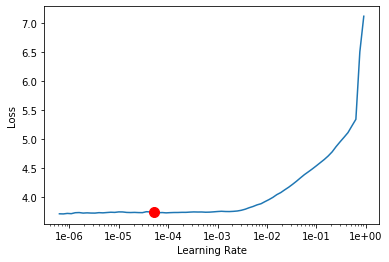

In [8]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [10]:
learner.fit_one_cycle(5, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,3.738090,4.372080,0.891459,0.810106,0.710626,0.669207,0.603721,0.651684,0.637434,0.773072,0.717829,01:26
1,3.755012,4.390665,0.891356,0.809428,0.704873,0.662701,0.599459,0.642319,0.629087,0.769907,0.713165,01:17
2,3.631645,5.149435,0.889913,0.810158,0.707476,0.663153,0.602841,0.651945,0.634276,0.770468,0.715786,01:24
3,3.552549,4.516122,0.889707,0.808593,0.705482,0.663545,0.598251,0.649852,0.632506,0.769613,0.714113,01:18
4,3.464313,4.542672,0.889913,0.807758,0.704610,0.660885,0.597157,0.645447,0.632195,0.768598,0.712736,01:20


In [11]:
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=256, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=64)
        .normalize(imagenet_stats))

data.c = 16
data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: PoseLabelList
Pose (8/16) (256, 256),Pose (7/16) (256, 256),Pose (6/16) (256, 256),Pose (14/16) (256, 256),Pose (1/16) (256, 256)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: PoseLabelList
Pose (14/16) (256, 256),Pose (16/16) (256, 256),Pose (10/16) (256, 256),Pose (16/16) (256, 256),Pose (10/16) (256, 256)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [12]:
learner.data = data

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 1.32E-03


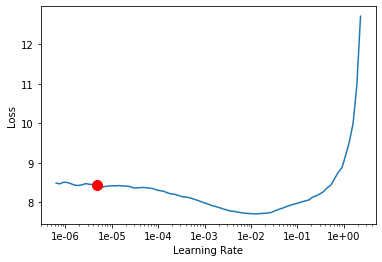

In [13]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(20, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,6.440937,6.027540,0.868638,0.777577,0.631571,0.603886,0.466261,0.445029,0.436896,0.723803,0.619372,03:56
1,6.036236,5.710155,0.888471,0.806189,0.686157,0.666060,0.531099,0.563126,0.514143,0.764551,0.677360,03:48
2,5.818324,5.544089,0.900268,0.823470,0.719086,0.694934,0.572360,0.618038,0.561075,0.787042,0.709358,03:58
3,5.665926,5.455681,0.905316,0.832396,0.736284,0.711629,0.590657,0.646906,0.603856,0.798835,0.727578,04:00
4,5.594783,5.415974,0.906244,0.836942,0.746458,0.720024,0.609954,0.667926,0.625206,0.804752,0.739057,03:57
5,5.487179,5.360204,0.910159,0.844251,0.759686,0.729332,0.620077,0.682751,0.642371,0.813113,0.749431,04:04
6,5.385045,5.363016,0.912374,0.843049,0.760264,0.731098,0.620592,0.686821,0.650557,0.813927,0.751401,04:06
7,5.298665,5.362299,0.912271,0.847750,0.768597,0.737264,0.622192,0.692910,0.662538,0.818629,0.756584,03:57
8,5.220698,5.495694,0.912940,0.848275,0.769007,0.737608,0.623945,0.695750,0.666031,0.819109,0.757870,03:57
9,5.150656,5.394181,0.911807,0.849316,0.771508,0.741081,0.626078,0.702568,0.673919,0.820539,0.760770,03:55


### with BU loss

In [4]:
def loss_with_bu(outputs, targets):
    bu, td = outputs
    is_visible = targets[..., 2] > 0
    bu_loss = F.binary_cross_entropy_with_logits(bu, is_visible.float())
    
    gt = targets[is_visible][..., :2]
    td_loss = pose.ce_loss(td[is_visible], gt)
    return bu_loss + td_loss

thresh = 0.8
def acc(last_output, last_target):
    return accuracy_thresh(last_output[0], last_target[..., 2].clamp(0, 1), thresh=thresh)
acc.__name__ = f'accuracy@{thresh}'

learner = short_unet_learner(data, models.resnet18, bu=True, callback_fns=pose.Pckh, loss_func=loss_with_bu, metrics=acc)

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 4.37E-02


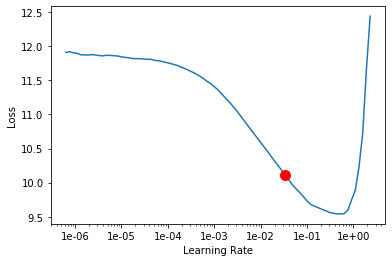

In [14]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [15]:
lr = 1e-2
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,5.827571,5.424439,0.744531,0.828817,0.668770,0.494192,0.456948,0.416941,0.423488,0.479574,0.616716,0.547696,02:12
1,5.448817,5.125332,0.849937,0.832887,0.691479,0.528692,0.508344,0.465761,0.463586,0.497176,0.644443,0.579068,02:12
2,5.226659,4.974235,0.772144,0.865753,0.745038,0.607815,0.561182,0.513229,0.535921,0.536590,0.698707,0.633010,02:09
3,5.094832,4.937772,0.734231,0.866629,0.759187,0.623282,0.592685,0.533288,0.572027,0.565430,0.713879,0.653001,02:11
4,4.888134,6.157865,0.769150,0.883629,0.789794,0.666868,0.627574,0.571095,0.609846,0.588220,0.745145,0.685180,02:16
5,4.746498,11.527484,0.789119,0.890326,0.800343,0.683140,0.641565,0.582249,0.617820,0.605556,0.756912,0.696964,02:13
6,4.574724,5.120517,0.815763,0.892386,0.810050,0.701528,0.665654,0.598646,0.644585,0.621574,0.770227,0.712728,02:10
7,4.404543,5.059924,0.808338,0.894704,0.814386,0.712988,0.668778,0.606614,0.649174,0.637572,0.775490,0.719461,02:19
8,4.171819,5.092654,0.816600,0.894550,0.815428,0.716412,0.676030,0.606780,0.653493,0.635482,0.778308,0.721546,02:14
9,4.083263,5.896209,0.806087,0.892335,0.813760,0.712456,0.672226,0.604319,0.651069,0.637111,0.775409,0.719255,02:12


In [16]:
learner.save('csunet-stage1')

In [5]:
learner.load('csunet-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None, model=CSUnet(
  (unet): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(ke

In [6]:
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=256, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=64)
        .normalize(imagenet_stats))

data.c = 16
data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: PoseLabelList
Pose (8/16) (256, 256),Pose (7/16) (256, 256),Pose (6/16) (256, 256),Pose (14/16) (256, 256),Pose (1/16) (256, 256)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: PoseLabelList
Pose (14/16) (256, 256),Pose (16/16) (256, 256),Pose (10/16) (256, 256),Pose (16/16) (256, 256),Pose (10/16) (256, 256)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [7]:
learner.data = data

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 1.32E-03


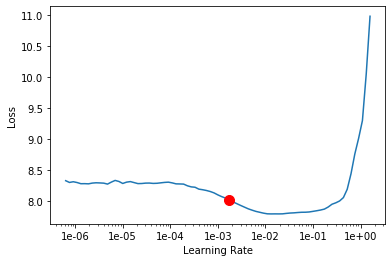

In [20]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [8]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,6.552603,14.813288,0.766569,0.879301,0.793762,0.663413,0.644909,0.488588,0.494328,0.489713,0.748324,0.649688,03:45
1,6.174311,6.590422,0.823294,0.897486,0.817412,0.714303,0.694148,0.556678,0.597879,0.548373,0.783396,0.700862,03:34
2,6.049829,32.260113,0.833669,0.905213,0.829005,0.740632,0.716278,0.585916,0.642218,0.591137,0.800118,0.725715,03:35
3,5.887832,13.416963,0.826344,0.909283,0.837462,0.750106,0.723383,0.601330,0.659477,0.617376,0.807370,0.737474,03:34
4,5.833187,9.193025,0.847375,0.909644,0.839184,0.755796,0.731755,0.606565,0.669377,0.630436,0.811296,0.743325,03:34
5,5.738348,10.292198,0.840581,0.910262,0.844198,0.765113,0.735778,0.615482,0.677066,0.643211,0.815984,0.749885,03:34
6,5.665375,11.322403,0.832937,0.912322,0.845399,0.760402,0.738337,0.619901,0.680392,0.646313,0.816291,0.751492,03:34
7,5.638445,7.263647,0.841056,0.911910,0.845246,0.763674,0.736608,0.622582,0.685784,0.649951,0.816532,0.753107,03:34
8,5.620782,5.688106,0.837281,0.912271,0.845871,0.762956,0.736900,0.623343,0.684468,0.647854,0.816679,0.752925,03:34
9,5.564662,11.656676,0.825544,0.912322,0.845506,0.763878,0.737351,0.623016,0.685977,0.648633,0.816932,0.753304,03:34


In [9]:
learner.save('csunet-256-stage1')

In [17]:
learner.load('csunet-256-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: PoseLabelList
Pose (8/16) (256, 256),Pose (7/16) (256, 256),Pose (6/16) (256, 256),Pose (14/16) (256, 256),Pose (1/16) (256, 256)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: PoseLabelList
Pose (14/16) (256, 256),Pose (16/16) (256, 256),Pose (10/16) (256, 256),Pose (16/16) (256, 256),Pose (10/16) (256, 256)
Path: /home/labs/waic/omrik/LIP;

Test: None, model=CSUnet(
  (unet): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(ke

In [18]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.29E-07


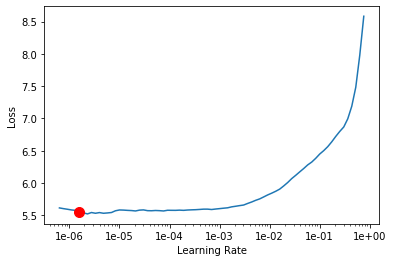

In [12]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [19]:
learner.fit_one_cycle(20, slice(1e-7, 5e-4))

epoch,train_loss,valid_loss,accuracy@0.8,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,5.572331,8.214993,0.829369,0.912168,0.846237,0.764698,0.737458,0.623562,0.686042,0.649399,0.817306,0.753708,03:45
1,5.588858,5.711632,0.824656,0.911344,0.845767,0.763759,0.736837,0.624375,0.686308,0.651261,0.816599,0.753626,03:47
2,5.589170,6.496985,0.842444,0.911034,0.847385,0.765743,0.739427,0.626948,0.687232,0.651648,0.818028,0.755051,03:46
3,5.554561,5.731651,0.846550,0.910468,0.844460,0.766562,0.737806,0.624159,0.687433,0.657372,0.816946,0.754598,03:49
4,5.518148,5.706193,0.850381,0.909489,0.846182,0.765823,0.740101,0.625092,0.691298,0.656281,0.817493,0.755447,03:46
5,5.514608,5.704229,0.839750,0.910777,0.846445,0.765568,0.739448,0.625240,0.690367,0.657054,0.817680,0.755554,03:46
6,5.456729,5.850249,0.844075,0.908922,0.845873,0.764588,0.740721,0.627272,0.689529,0.661703,0.817119,0.755900,03:44
7,5.392413,11.819403,0.853662,0.908407,0.845663,0.767431,0.738548,0.627491,0.690507,0.662387,0.817106,0.756123,03:44
8,5.371634,5.706937,0.852763,0.908150,0.844670,0.765405,0.737893,0.625410,0.689331,0.663009,0.816131,0.755126,03:45
9,5.301349,5.743189,0.849669,0.907840,0.845247,0.765973,0.736826,0.626070,0.690517,0.661546,0.816091,0.755192,03:44
